<a id='Notebook_Date'></a> Created: 2024/02/07

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\cal H}} $
$ \newcommand{\cg}[1]{{\rm C}#1} $
$ \newcommand{\lp}{\left(} $
$ \newcommand{\rp}{\right)} $
$ \newcommand{\lc}{\left[} $
$ \newcommand{\rc}{\right]} $
$ \newcommand{\lch}{\left\{} $
$ \newcommand{\rch}{\right\}} $
$ \newcommand{\Lp}{\Bigl(} $
$ \newcommand{\Rp}{\Bigr)} $
$ \newcommand{\Lc}{\Bigl[} $
$ \newcommand{\Rc}{\Bigr]} $
$ \newcommand{\Lch}{\Bigl\{} $
$ \newcommand{\Rch}{\Bigr\}} $
$ \newcommand{\rqa}{\quad \Rightarrow \quad} $

# 2. Implementación simple

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
# import qiskit.tools.jupyter
# import math
from math import gcd
import pandas as pd
from numpy.random import randint
from fractions import Fraction
%matplotlib inline

# Import qibo libraries
from qibo.models import Circuit
from qibo import  gates

<a id='sec_FTA_shor_simple_indice'></a>
## Índice

- **[2.1 - Hallar del periodo de una función (Period Finding)](#sec_FTA_shor_Period-Finding)**
    - **[2.1.1 - La función](#sec_FTA_shor_La-función)**
    - **[2.1.2 - Solución: Estimación de fase de un operador U](#sec_FTA_shor_Solución)**
- **[2.2 - Implementación (ad hoc) para $N=15$](#sec_FTA_shor_Implementación-(ad-hoc))**
    - **[2.2.1 - Caso con muchos shots (ineficiente pero didáctico)](#sec_FTA_shor_multishot)**
    - **[2.2.2 - Caso shot a shot (óptimo)](#sec_FTA_shor_shot-a-shot)**

- **[Bibliografía](#sec_FTA_Shor_Al_simple_Bibliografía)**

El algoritmo de Shor se basa en el algoritmo de **Estimación de Fase Cuántica (Quantum Phase Estimation)** ([[1]](#bib_FTA_IPE_QSS_CICC_QPE) y [[4]](#bib_FTA_IPE_QSS_Qiskit_QPE)), que a su vez usa la **Transformada de Fourier Cuántica (Quantum Fourier Transform)** ([[2]](#bib_FTA_IPE_QSS_CICC_QFT) y [[5]](#bib_FTA_IPE_QSS_Qiskit_QFT)). El algoritmo de Shor lo que hace es convertir el problema de la factorización  de un número en un problema de **encontrar el periodo de una función**, el cual puede ser implementado en un tiempo polinómico. 

Para factorizar un número $N$ básicamente el algoritmo de Shor lo que hace calcular el periodo de una función (periódica) de la forma

\begin{equation}
f(x) = a^x \text{mod} N
\end{equation}

donde $a$ y $N$ son enteros positivos mayores que 1, siendo además $a$ < $N$ y no teniendo factores comunes. La operación ($z$ mod$N$) a lo que se refiere es a quedarnos con el **resto** de dividir el número que $z$ por $N$. El periodo $r$ de esta función se calcula mediante el algoritmo de estimación de fase cuántica. Una vez se tiene el periodo $r$, si este es par (sino hay que probar con otro valor de $a$) se pueden calcular los factores de $N$ ya que existe una alta probabilidad de que el máximo común divisor de $N$ y $a^{\,r/2}-1$ o $a^{\,r/2}+1$ sea un factor propio de $N$.

En esta guía vamos a seguir la explicación del Notebook de Qiskit [[7]](#bib_FTA_Shor_Qiskit_Shor).

<a id='sec_FTA_shor_Period-Finding'></a>
## 2.1 - Hallar del periodo de una función (Period Finding)

<a id='sec_FTA_shor_La-función'></a>
### 2.1.1 - La función

Como comentamos en la introducción, lo que queremos es hallar el periodo de la función 

$$
f(x) = a^x \text{mod } N
$$

donde $a$ y $N$ son enteros positivos mayores que 1, siendo además $a$ < $N$ y no teniendo factores comunes. La operación ($z$ mod$N$) a lo que se refiere es a quedarnos con el **resto** de dividir el número que $z$ por $N$. A este tipo de funciones se las denomina **exponenciales moduladas**.

Denominaremos $r$ al valor del periodo de la función $f(x)$, es decir, $r$ es el mínimo valor entero para que se cumple:
    
$$
f(x+r) = f(x)
$$

En la siguiente figura vemos un ejemplo de este tipo de funciones con $a = 3$ y $N=35$. Vemos que para este caso el periodo es $r = 12$. (Véase que las lineas puntuadas que unen las cruces son solo por estética).

Value from f(0) to f(r):
[1.0, 3.0, 9.0, 27.0, 11.0, 33.0, 29.0, 17.0, 16.0, 13.0, 4.0, 12.0, 1.0]


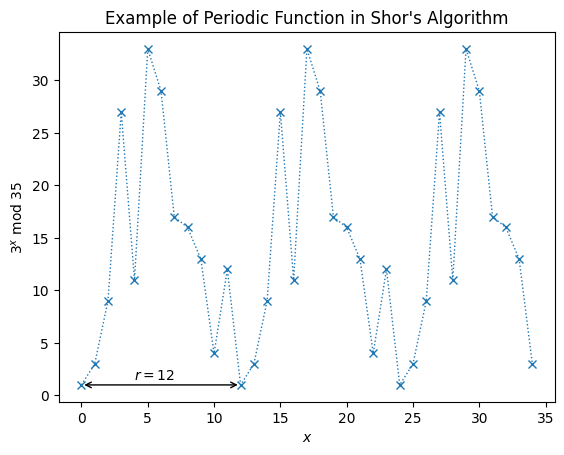

In [2]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35, dtype = float)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
    print('Value from f(0) to f(r):')
    print(yvals[:r+1])
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

<a id='sec_FTA_shor_Solución'></a>
### 2.1.2 - Solución: Estimación de fase de un operador U

El algoritmo de Shor se basa en implementar el algoritmo de estimación de fases al operador unitario

$$
U |y \rangle \equiv | ay \, \text{mod} N \rangle
$$

Al aplicar sucesivas veces el operador $U$ sobre el estado $|1 \rangle$ vamos obteniendo los valores de $f(x)$ con $x \in \mathbb{N}$, esto es,

$$
U^x |1 \rangle = | f(x) \rangle
$$

Por ejemplo, para el caso que vimos en la gráfica anterior ($a=3$ y $N=35$) tenemos

\begin{align}
U^0 |1\rangle & = |1\rangle \\
U |1\rangle & = |3\rangle \\
U^2 |1\rangle & = |9\rangle \\
\vdots \\
U^{r-1} |1\rangle & = |12\rangle \\
U^r |1\rangle & = |1\rangle
\end{align}

(Recordemos que dado un estado de $n$ qubits $\left| x \right\rangle$ tenemos que $\left| x \right\rangle = \left| x_1 x_2 \dots x_n \right\rangle$ donde $x_1$ es el bit más significativo.)

Como podemos ver, aplicar una vez más el operador $U$ significa pasar de un número al siguiente de la lista periódica. Veámoslo explícitamente:

\begin{align}
U(U^0 |1\rangle) & = U(|1\rangle) = |3\rangle \\
U(U |1\rangle) & = U(|3\rangle) = |9\rangle \\
U(U^2 |1\rangle) & = U(|9\rangle) = |27\rangle\\
\vdots \\
U(U^{r-1} |1\rangle) & = U(|12\rangle) =|1\rangle \\
U(U^r |1\rangle) & = U(|1\rangle) = |3\rangle
\end{align}

Con esto se entiende fácilmente que la superposición equiprobable de todos los estados es un autoestado del operador $U$ con autovalor 1:

$$
| u_0 \rangle = \frac{1}{\sqrt{r}} \sum^{r-1}_{k=0} |a^k \, \text{mod} N \rangle, \qquad \text{donde} \quad U|u_0 \rangle = |u_0\rangle
$$

<a id="Ejemplo:-caso-con-a=3-y-N=35"></a>
<details><summary><p style="color:blue" > >> <i>Ejemplo</i> </p></summary>
<div class="alert alert-block alert-success">
<p style="color: DarkGreen;">
<b>Ejemplo</b>: <i>Subtitulo del ejercicio/ejemplo</i>
<br>        
\begin{align}
U |u_0 \rangle & = U \left[ \frac{1}{\sqrt{12}} \left( |1 \rangle + |3\rangle + |9 \rangle + \dots |4 \rangle + |12 \rangle \right) \right] = \\
& = \frac{1}{\sqrt{12}} \left( U|1 \rangle + U|3\rangle + U|9 \rangle + \dots U|4 \rangle + U|12 \rangle \right) = \\
& =\frac{1}{\sqrt{12}} \left( |3 \rangle + |9\rangle + |27 \rangle + \dots |12 \rangle + |1 \rangle \right) = \\
& =  |u_0 \rangle
\end{align}
</div>
</details>


Un autoestado de autovalor 1 no nos es muy interesante a la hora de aplicar el algoritmo de estimación fase. Otro conjunto de autoestados mucho más interesantes son aquellos de la forma:

$$
| u_s \rangle = \frac{1}{\sqrt{r}} \sum^{r-1}_{k=0} e^{- \boldsymbol{2 \pi i}k \frac{s}{r}} |a^k \, \text{mod} N \rangle, \qquad \text{donde} \quad U|u_s \rangle = e^{\boldsymbol{2 \pi i} \frac{s}{r}}|u_s\rangle
$$

donde $0 \leq s \leq r-1$. Si ahora aplicamos el algoritmo de estimación de fase cuántica a uno de estos autoestados $|u_s \rangle$, lo que obtendremos en el registro de conteo es $|2^n s/r \rangle$. De aquí podemos extraer el valor de $r$. Sin embargo, para preparar el estado $|u_s \rangle$ tenemos que conocer $r$, es decir, lo que queremos calcular. 

Un solución elegante y fácil de implementar es darnos cuenta de que la suma de todos estos estados $|u_s \rangle$ nos da el estado $|1\rangle$, esto es,

$$
\frac{1}{r} \sum_{s=0}^{r-1} |u_s \rangle = \frac{1}{r} \left(|u_0 \rangle + |u_1 \rangle + \dots +|u_{r-1} \rangle \right)  = | 1 \rangle
$$

Si ahora aplicamos el algoritmo de estimación de fase cuántico (QPS) al estado |1> (un estado fácilmente implementable) obtenemos una superposición equiprobable de estados de la forma $|2^n s/r \rangle$, es decir:

$$ 
|0 \rangle|1 \rangle \xrightarrow{QPS} \frac{1}{\sqrt{r}} \left( \left|2^t \frac{1}{r} \right\rangle + \left|2^t \frac{2}{r} \right\rangle + \dots + \left|2^t \frac{r-1}{r} \right\rangle \right) |1 \rangle
$$

donde $t$ es el número de qubits del registro de conteo.
Usando el las fracciones continuas [[6]](#bib_FTA_Shor_CF) podemos calcular $r$ a partir de los cocientes $s/r$.

En la siguiente imagen podemos ver el circuito (en el orden de Qiskit para los qubits) que implementa la estimación de fase cuántica (figura tomada de [[7]](#bib_FTA_Shor_Qiskit_Shor))

<figure><center>
<img src="Figuras_Shor/Fig-3_QPE-Shor.png" alt="" align=center width='1000px'/>
</center></figure>

<div class="alert alert-block alert-danger">
<p style="color: DarkRed;">
<b>Nota</b>:
<br>     
Denominamos <i>$n$ al número de qubits que necesitamos para codificar el número $N$ </i>(que queremos factorizar) en un registro cuántico. Para aplicar el algoritmo de Shor se suelen usar $t=2n$ qubits en el <i>registro de conteo</i>.
</div>

<div class="alert alert-block alert-danger">
<p style="color: DarkRed;">
<b>Nota</b>:
<br>     
Véase que este circuito sigue el convenio más extendido en la literatura, es decir, aquel en el que el <b>bit más significativo</b> es el de más arriba y el bit menos significativo el de más abajo. Qiskit sigue el convenio contrario. Esto es, dado un estado
<br>
$$
\left| x \right\rangle = \left| a_{n-1} a_{n-2} \dots a_1 a_0 \right\rangle
$$
<br>
que podemos escribirlo en la base decimal como
<br>
$$
x = a_{n-1} 2^{n-1} + a_{n-2} 2^{n-2} + \dots + a_0 2^{0}
$$
<br>
tenemos que al escribir los circuitos
    
<figure><center>
<img src="Figuras_Shor/Fig-2_convenios.png" alt="" align=center width='300px'/>
</center></figure>
<p style="color: DarkRed;">  
En este caso, para escribir el circuito en el convenio de qiskit lo que habría que hacer es invertir los qubits que controlan las puertas $U$, es decir, aplicar $U^{2^{t-1}}$ controlada por el último qubit, $U^{2^{t-2}}$ controlada el penúltimo qubit, ... y $U^{2^{0}}$ controlada por el primer qubit. 
</p>
</div>

<a id='sec_FTA_shor_Implementación-(ad-hoc)-en-Qiskit'></a>
## 2.2 - Implementación (ad hoc) en Qiskit para $N=15$

En esta sección vamos a ver una implementación un poco *ad hoc* del algoritmo de Shor para factorizar el número 15. Con lo de *ad hoc* a lo que nos referimos es a que el oráculo que representa la exponencial modulada del operador $U$ está construido específicamente para el caso de factorizar 15 y no se va a explicar como funciona. El objetivo de esta sección es ver como tratamos los resultados del circuito, aplicando el método de las fracciones continuas [[6]](#bib_FTA_Shor_CF) para obtener $r$ y no tanto ver como se construye el oráculo. 

En concreto, el caso que vamos a resolver es el de $a=7$ y $N=15$. Es fácil ver que para este caso tenemos un periodo de $r = 4$, donde los cuatro posibles estados son $| 1 \rangle$, $| 7 \rangle$, $| 4 \rangle$ y $| 13 \rangle$. 

<div class="alert alert-block alert-danger">
<p style="color: DarkRed;">
<b>Nota</b>:
<br>     
Un <b>oráculo</b> es, por decirlo así, la forma que se usa en computación cuántica para denominar a las funciones de las cuales queremos extraer información haciendo llamadas a las mismas. El oráculo es una función que desconoces cómo está hecha, sólo sabes lo que hace. Como a los oráculos griegos, sólo te está permitido interrogarles, pero no preguntarles cómo saben que esa es la respuesta.
<br>
Al final los oráculos se representan como secciones del circuito que se dedica a aplicar un operador $U$. En nuestro caso, por ejemplo, llamamos oráculo a la función que construye el operador de la exponencial modulada $U^{2^j} |y \rangle = | a^{2^j}y \, \text{mod} N \rangle$.
</p>
</div>

<a id='sec_FTA_shor_multishot'></a>
### 2.2.1 - Caso con muchos shots (ineficiente pero didáctico)

Como el número elegido para la factorización es pequeño (necesitamos pocos qubits) vamos a lanzar varios shots al circuito para ver todos los posibles resultado. Veremos que esto es en realidad una perdida de tiempo, pues no nos hace falta tener toda la distribución. Es simplemente un caso pedagógico para entender como lidiar con los resultados del circuito.

Veamos pues el código (el código se he tomado del textbook de Qiskit [[7]](#bib_FTA_Shor_Qiskit_Shor)) :

**Oráculos**:

In [3]:
'''Qiskit_code_cell'''
# Oracle: Modular Exponentiation U^{2^j} |y> = |a^{2^j}y mod N> 
def c_amod15(a, power): # It use 4 
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

# Inverse Quantum Fourier Transformation of n qubits
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [4]:
'''Qibo_code_cell'''
# Oracle: Modular Exponentiation U^{2^j} |y> = |a^{2^j}y mod N> 
def c_amod15_qibo(a, power): # It use 4+1 control qubit 
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = Circuit(5)
    # El qubit 0 se utilizará para controlar el resto de las puertas del circuito, mientras que los 
    # otros cuatro qubits hacen las veces de bits para representar los números que se multiplican.
    # Recordemos que qibo utiliza el convenio estándar en la literatura, en el que el bit más
    # significativo es el de más abajo y el menos significativo el de arriba (al contrario que Qiskit)
    for iteration in range(power):
        if a in [2,13]:
            U.add(gates.SWAP(4, 3).controlled_by(0))
            U.add(gates.SWAP(3, 2).controlled_by(0))
            U.add(gates.SWAP(2, 1).controlled_by(0))
        if a in [7,8]:
            U.add(gates.SWAP(2, 1).controlled_by(0))
            U.add(gates.SWAP(3, 2).controlled_by(0))
            U.add(gates.SWAP(4, 3).controlled_by(0))
        if a in [4, 11]:
            U.add(gates.SWAP(3, 1).controlled_by(0))
            U.add(gates.SWAP(4, 2).controlled_by(0))
        if a in [7,11,13]:
            for q in range(1,5):
                U.add(gates.X(q).controlled_by(0))
    return U
# Inverse Quantum Fourier Transformation of n qubits
def qft_dagger_qibo(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = Circuit(n)
    phase = []
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.add(gates.SWAP(qubit, n-qubit-1))
    for j in range(n):
        for m in range(j):
            qc.add(gates.CU1( n-m-1 , n-j-1, -np.pi/float(2**(j-m)) ))
        qc.add(gates.H(n-j-1))
    qc.name = "QFT†"
    return qc

**Circuito**

C:\Users\FRANCISCO\PycharmProjects\Algoritmo de Shor\.venv2\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


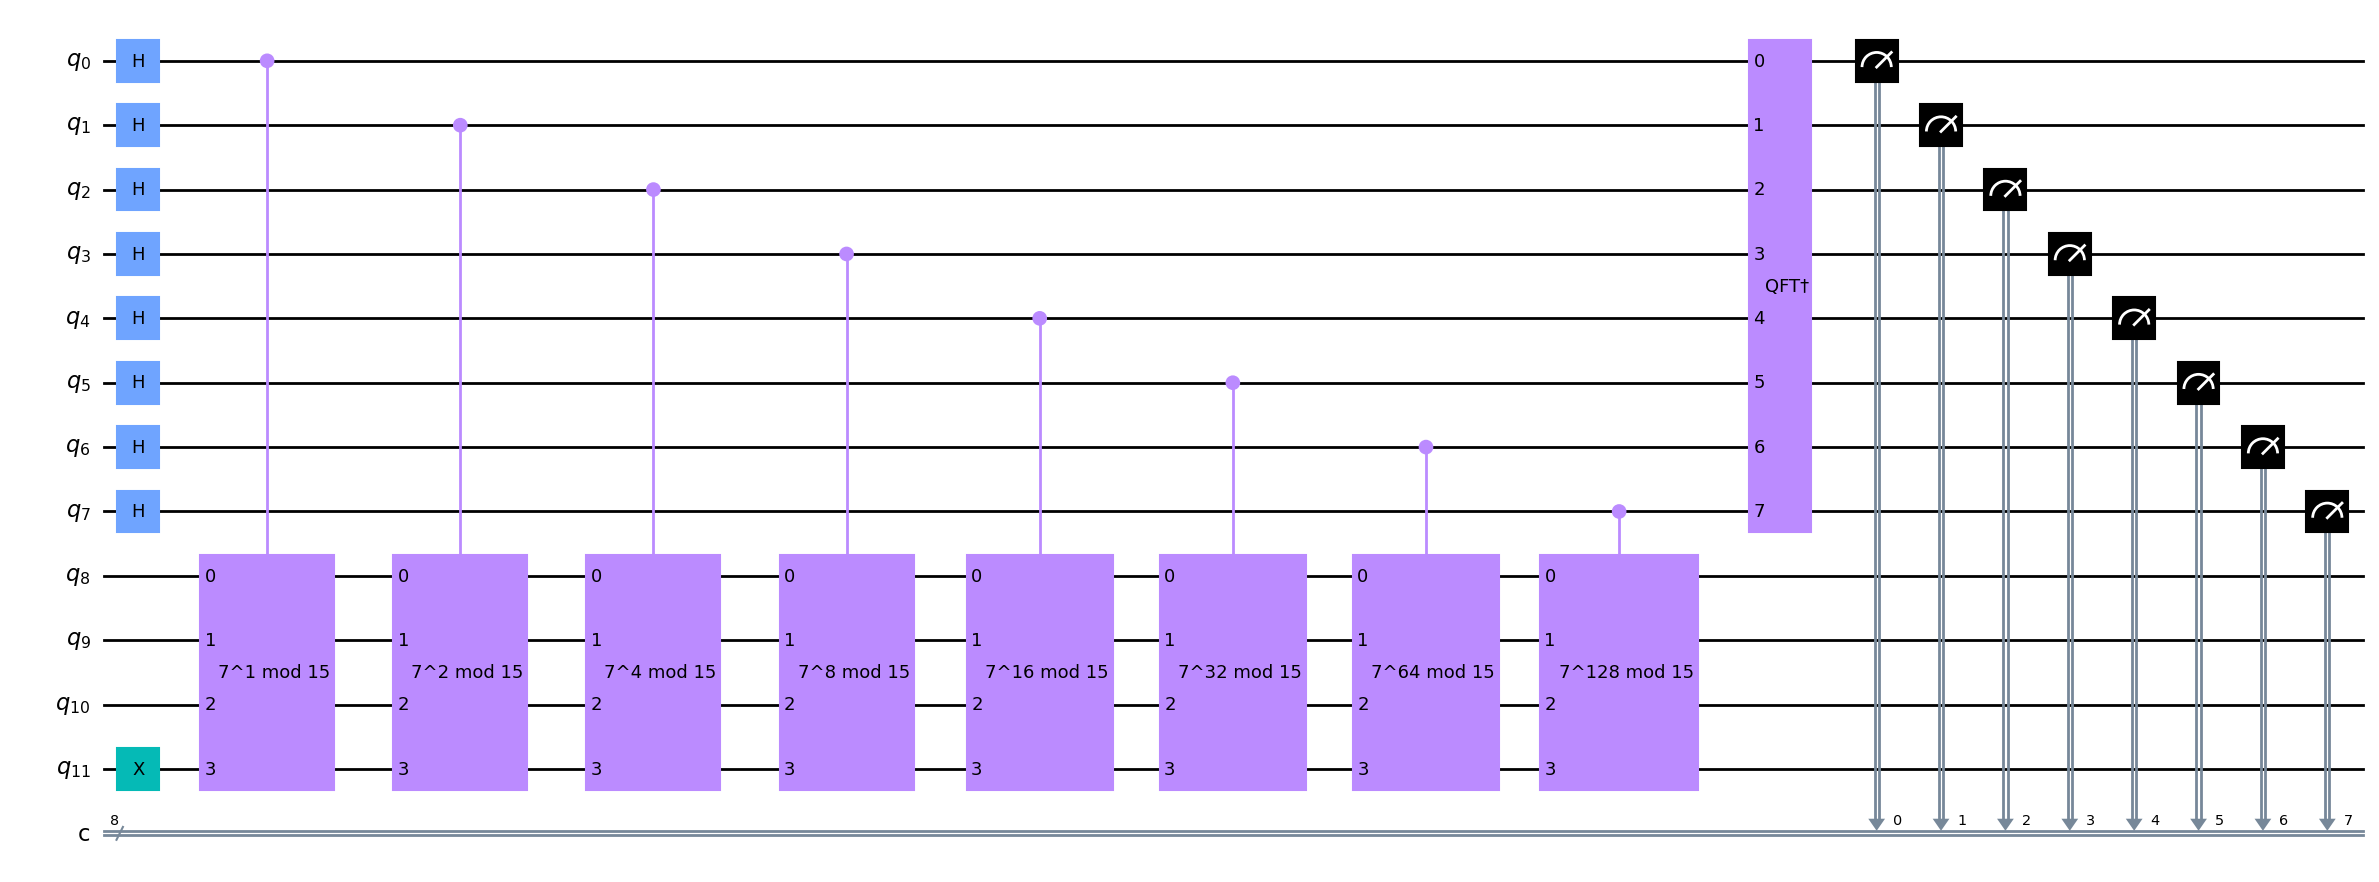

In [5]:
'''Qiskit_code_cell'''
# Specify variables
n_count = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(output = 'mpl', fold=-1)  # -1 means 'do not fold'

In [6]:
'''Qibo_code_cell'''
# Specify variables
n_count = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qcc = Circuit(n_count + 4)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qcc.add(gates.H(q))  

# And auxiliary register in state |1>
qcc.add(gates.X(n_count))

# Do controlled-U operations
for q in range(n_count):
    qcc.add(c_amod15_qibo(a, 2**q).on_qubits(*[n_count-q-1]+[i+n_count for i in range(4)]))
# Do inverse-QFT
qcc.add(qft_dagger_qibo(n_count).on_qubits(*range(n_count)))
# Measure circuit
#qcc.add(gates.M(*reversed(range(n_count)), register_name='results'))
qcc.add(gates.M(*range(n_count), register_name='results'))
print(qcc.draw(line_wrap=100, legend=False))

q0 :     ─H────────────────────────────────────────────────────────────────────────────────────────────────── ...
q1 :     ─H────────────────────────────────────────────────────────────────────────────────────────────────── ...
q2 :     ─H────────────────────────────────────────────────────────────────────────────────────────────────── ...
q3 :     ─H────────────────────────────────────────────────────────────────────────────────────────────────── ...
q4 :     ─H────────────────────────────────────────────────────────────────────────────────────────────────── ...
q5 :     ─H───────────────────────────────────────────o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o─o ...
q6 :     ─H───────────────o─o─o─o─o─o─o─o─o─o─o─o─o─o─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─| ...
q7 :     ─H─o─o─o─o─o─o─o─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─|─| ...
q8 :     ─X─x─|─|─X─|─|─|─x─|─|─X─|─|─|─x─|─|─X─|─|─|─x─|─|─X─|─|─|─x─|─|─X─|─|─|─x─|─|─

**Simulación**

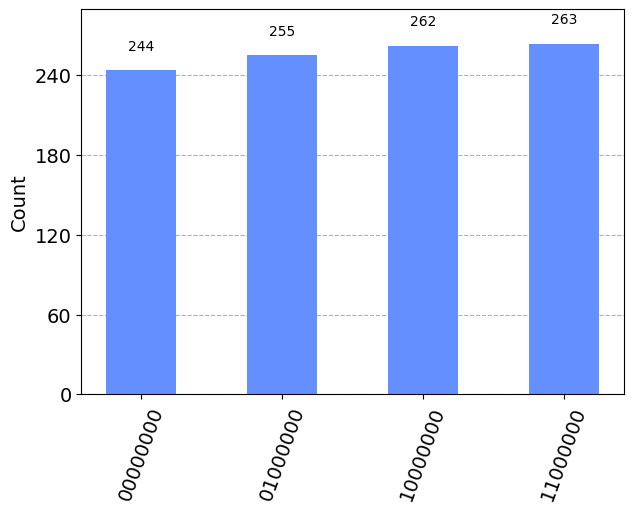

In [7]:
'''Qiskit_code_cell'''
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
results = aer_sim.run(t_qc).result()
counts = results.get_counts()
plot_histogram(counts)

[Qibo 0.1.12.dev0|INFO|2024-05-08 10:10:24]: Using numpy backend on /CPU:0


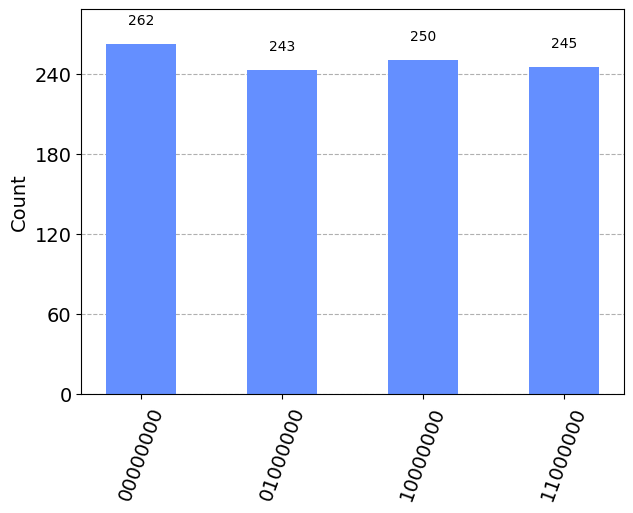

In [8]:
'''Qibo_code_cell'''

results_qibo = qcc.execute(nshots=1000)
counts_qibo = results_qibo.frequencies(binary=True)
plot_histogram(counts_qibo)

Como ya comentamos, el periodo para el caso elegido sabemos de antemano que es $r = 4$. Podemos ver que efectivamente, al lanzar varios shots al circuito (ejecutarlo varias veces) y ver todos los resultados tenemos 4 posibilidades, correspondientes a las 4 fases $s/r$ con $0 \leq s \leq r$. Esto no es lo habitual al aplicar el algoritmo de Shor, pues cuantos más grande es el número que queremos factorizar, más qubits necesitamos, más complejo se vuelve el circuito y más shots necesitamos para reconstruir la distribución de probabilidad. 

Lo óptimo es lanzar un shot, ver que valor de $r$ obtenemos con el resultado y intentar hallar los divisores de $N$ con este $r$. Si no funciona, lanzamos otro shot y probamos a calcular otra vez $r$ con el nuevo resultado. Repetimos el proceso hasta encontrar los factores. Esto será lo que haremos en la sección [2.2.2 - Caso shot a shot (óptimo)](#sec_FTA_shor_shot-a-shot). 

<div class="alert alert-block alert-danger">
<p style="color: DarkRed;">
<b>Nota</b>:
<br>     
Se trata de una simulación ideal, sin ruido. En un ordenador cuántico de verdad tendríamos más resultados con probabilidades bajas y estos 4 sobresaliendo.
</p>
</div>

Para obtener los 4 valores de $r$ correspondientes a los 4 resultados que acabamos de obtener, primero debemos recordar que estos resultados son los valores $2^n s/r$ para $0 \leq s \leq r$, con $s$ siendo un número entero. Lo primero que debemos hacer es pasar nuestros resultados de binario a decimal, después dividir por $2^n$. 

Una vez hecho esto tendremos números reales entre 0 y 1. Debemos aproximar estos números por una fracción. Para ello podemos usar la función de python [Fraction()](https://docs.python.org/3/library/fractions.html) de python. Como sabemos que el periodo de la función $a^x$ mod $N$ no puede mayor que $N$, podemos usar Fraction().limit_denominator(N) para limitar el valor del denominador. Tenemos pues:


In [9]:
'''Qiskit_code_cell'''
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    frac = Fraction(phase).limit_denominator(15)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{phase:.2f}",
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print the rows in a table
headers=["Register Output", "  Phase  ", "  Fraction  ", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output   Phase     Fraction    Guess for r
0  00000000(bin) =   0(dec)      0.00          0/1            1
1  01000000(bin) =  64(dec)      0.25          1/4            4
2  11000000(bin) = 192(dec)      0.75          3/4            4
3  10000000(bin) = 128(dec)      0.50          1/2            2


In [10]:
'''Qibo_code_cell'''
rows, measured_phases = [], []
for output in counts_qibo:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    frac = Fraction(phase).limit_denominator(15)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{phase:.2f}",
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print the rows in a table
headers=["Register Output", "  Phase  ", "  Fraction  ", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output   Phase     Fraction    Guess for r
0  00000000(bin) =   0(dec)      0.00          0/1            1
1  01000000(bin) =  64(dec)      0.25          1/4            4
2  10000000(bin) = 128(dec)      0.50          1/2            2
3  11000000(bin) = 192(dec)      0.75          3/4            4


Vemos varías cosas interesantes en este resultado. Primero, vemos que la opción predominante para el periodo es $r=4$, que como sabemos, es correcta (puede verse que para $a=7$ y $N=15$ las cuatro opciones posibles son $| 1 \rangle$, $| 7 \rangle$, $| 4 \rangle$ y $| 13 \rangle$). Vemos también que el algoritmo de Shor puede fallar. En concreto, falla cuando tenemos la fase del estado con $s = 0$ y cuando $s$ y $r$ tienen un factor común (en este caso tenemos que para $s = 2 \rightarrow 2/4 \rightarrow 1/2$).

Tenemos pues, que a parte de obtener valores erróneos de $r$ por el ruido (no presente en nuestra simulación ideal), el propio algoritmo de Shor nos puede dar valores de $r$ erróneos. 

Ahora solo faltaría aplicar lo comentado en la sección [1.5.2 - Factores de $N$ a partir del periodo $r$.](./Section_01-Introduccion.ipynb#sec_FTA_shor_Factores-N) para calcular los factores.

<a id='sec_FTA_shor_shot-a-shot'></a>
### 2.2.2 - Caso shot a shot (óptimo)

Después de la explicación didáctica de la sección anterior, vamos ahora a ver como hacer una implementación más útil. Para ello, en vez de lanzar varios shot al circuito, coger todos los resultados (o los más probables si tenemos ruido) y calcular los valores de $r$, lo que vamos hacer es ir shot a shot, calculando $r$ con cada resultado que nos de el circuito, hasta hallar los factores de N. Generalmente necesitaremos muchos menos shots, así que será más rápido.

In [11]:
# Number to be factored
N=15

Elegimos un número aleatorio, $a$, entre 1 y $N-1$

In [12]:
# Choose a random number, a, between 1 and N-1
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print('a = ', a)

a =  7


Verificamos que $a$ no es un factor de no trivial de $N$

In [13]:
#Next we quickly check it isn't already a non-trivial factor of N
from math import gcd # greatest common divisor
gcd(a, N)

1

<div class="alert alert-block alert-danger">
<b>Nota</b>:
<br>
    
Véase que el máximo común divisor se calcula usando la función gcd() del módulo [math](https://docs.python.org/3/library/math.html) de python. Esto es, se calcula clásicamente (sin ningún circuito cuántico), pues como ya comentamos, el algoritmo de Euclides [[3]](#bib_FTA_Shor_Euclides) se implementa de forma eficiente en un ordenado clásico. 

</div>

Ahora definimos una función que aplique el algoritmo de estimación de fases para fase $s/r$ donde 

$$
a^r \text{ mod} N = 1
$$

donde $s$ es un entero aleatorio entre 0 y $N-1$.

In [14]:
'''Qiskit_code_cell'''
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    result = aer_sim.run(t_qc, shots=1, memory=True).result() # One shot
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [15]:
'''Qibo_code_cell'''
def qpe_amod15_qibo(a):
    n_count = 8
    qc = Circuit(4+n_count)
    for q in range(n_count):
        qc.add(gates.H(q))     # Initialize counting qubits in state |+>
    # And auxiliary register in state |1>
    qc.add(gates.X(n_count))
    # Do controlled-U operations
    for q in range(n_count):
        qc.add(c_amod15_qibo(a, 2**q).on_qubits(*[n_count-q-1]+[i+n_count for i in range(4)]))
    # Do inverse-QFT
    qc.add(qft_dagger_qibo(n_count).on_qubits(*range(n_count)))
    # Add the measure gates
    qc.add(gates.M(*range(n_count), register_name='results'))
    
    ## Simulate Results ##
    results_qibo = qc.execute(nshots=1)
    readings = set(results_qibo.frequencies(binary= True)).pop()
    print("Register Reading: " + readings)
    phase = int(readings,2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase


Ejecutamos esta función hasta hallar los factores (por ejemplo, con un bucle while):

In [16]:
'''Qiskit_code_cell'''
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [20]:
'''Qibo_code_cell'''
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15_qibo(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Gues   ses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 11000000
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [23]:
%qiskit_version_table

---
<a id='sec_FTA_Shor_Al_simple_Bibliografía'></a>
## Bibliografía

[1]. [Curso básico de computación cuántica](https://talentq-es.github.io/TalentQ-CICC/docs/index.html) de [TalentQ], (https://www.talentq.es/es_es/), [Sección QPE](https://talentq-es.github.io/TalentQ-CICC/docs/Part_03_Algoritmos/Chapter_043_QPE_myst.html) <a id='bib_FTA_IPE_QSS_CICC_QPE'></a>

[2]. [Curso básico de computación cuántica](https://talentq-es.github.io/TalentQ-CICC/docs/index.html) de [TalentQ], (https://www.talentq.es/es_es/), [Sección QFT](https://talentq-es.github.io/TalentQ-CICC/docs/Part_03_Algoritmos/Chapter_042_QFT_myst.html) <a id='bib_FTA_IPE_QSS_CICC_QFT'></a>

[3]. [Algoritmo de Euclides](https://en.wikipedia.org/wiki/Euclidean_algorithm) <a id='bib_FTA_Shor_Euclides'></a>

[4]. [Quantum Phase Estimation (textbook Qiskit)](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-phase-estimation.ipynb) <a id='bib_FTA_IPE_QSS_Qiskit_QPE'></a>

[5]. [Quantum Fourier Transform (textbook Qiskit)](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb) <a id='bib_FTA_IPE_QSS_Qiskit_QFT'></a>


[6]. [Wikipedia contributors. "Continued fraction." Wikipedia, The Free Encyclopedia (2023)](https://en.wikipedia.org/wiki/Continued_fraction) <a id='bib_FTA_Shor_CF'></a>


[7]. [Shor's Algorithm (textbook Qiskit)](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb) <a id='bib_FTA_Shor_Qiskit_Shor'></a>








---
Autores:

David Castaño ([UMA-SCBI](https://www.scbi.uma.es/site/)), Raul Fuentes ([BSC-CNS](https://www.bsc.es/es)), Daniel Talaván  ([Cenits](https://www.cenits.es/)), Francisco Matanza ([UNICAN](https://web.unican.es/))

<img src="images/Logo_UMA.jpeg"  width="170px">
<img src="images/BSC-blue-medium.png" width="195px">
<img src="images/xaniversario_rectangle.jpg" width="170px">
<img src="images/Logo_UNICAM.jpg" width="210px">


---
<figure><center>
<img   src="https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png" align=center  width="2000px"/>
</center></figure>

<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<center>
<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />
</center>